# ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. In this notebook, we will use ARIMA to forecast the stock price of a Apple Inc. (AAPL) using historical data.

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv('AAPL_data.csv')
df.shape

(1259, 7)

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [7]:
df = df[['close']].copy()

In [9]:
#check for missing values
df.isnull().sum()

close    0
dtype: int64

In [8]:
df.describe()

,close
count,1259.000000
mean,109.066698
std,30.556812
min,55.789900
25%,84.830650
50%,109.010000
75%,127.120000
max,179.260000


An ARIMA model is characterized by 3 terms: p, d, q. Where,

- p is the order of the AR term
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term

We will use the `pmdarima` library to automatically find the best values for these terms.

## Stationarity

A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the time series models work on the assumption that the time series is stationary. We can check the stationarity of a time series using the Augmented Dickey-Fuller test.

## ADF test

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case if the p-value > 0.05, we will difference the time series and check the stationarity again.

In [10]:
# check if the series is stationary
from statsmodels.tsa.stattools import adfuller

resutls = adfuller(df['close'])
print('ADF Statistic: %f' % resutls[0])
print('p-value: %f' % resutls[1])

ADF Statistic: -0.665091
p-value: 0.855586


### Autocorrelation Function (ACF)

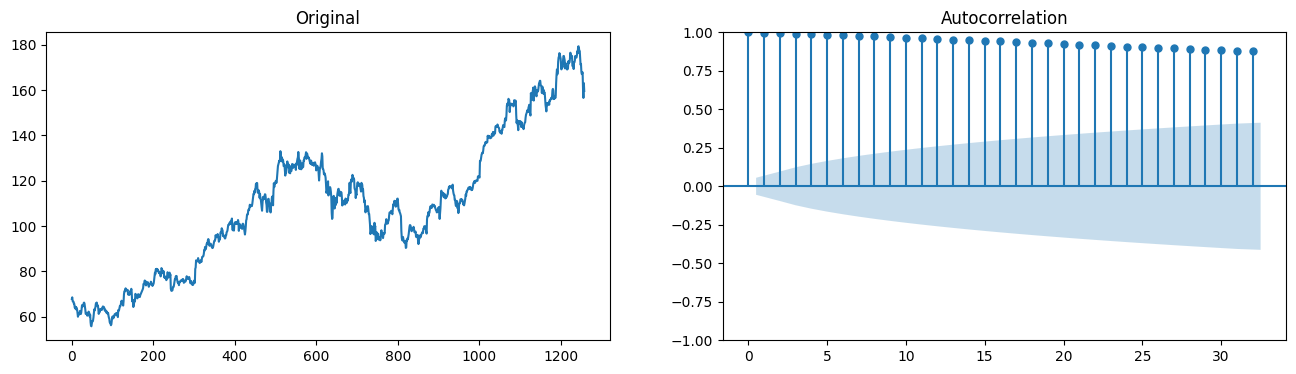

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df['close'])
ax1.set_title('Original')
plot_acf(df.close, ax=ax2);

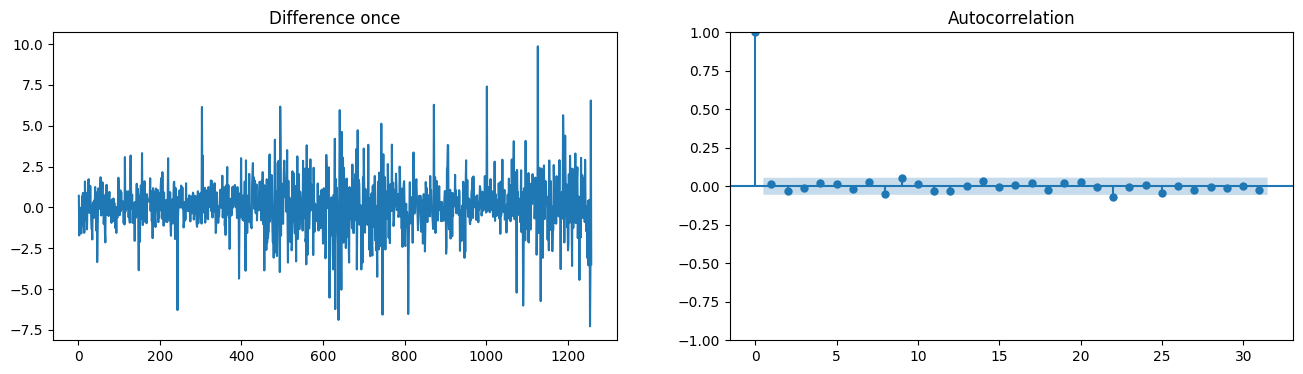

In [19]:
diff1 = df['close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title('Difference once')
plot_acf(diff1, ax=ax2);

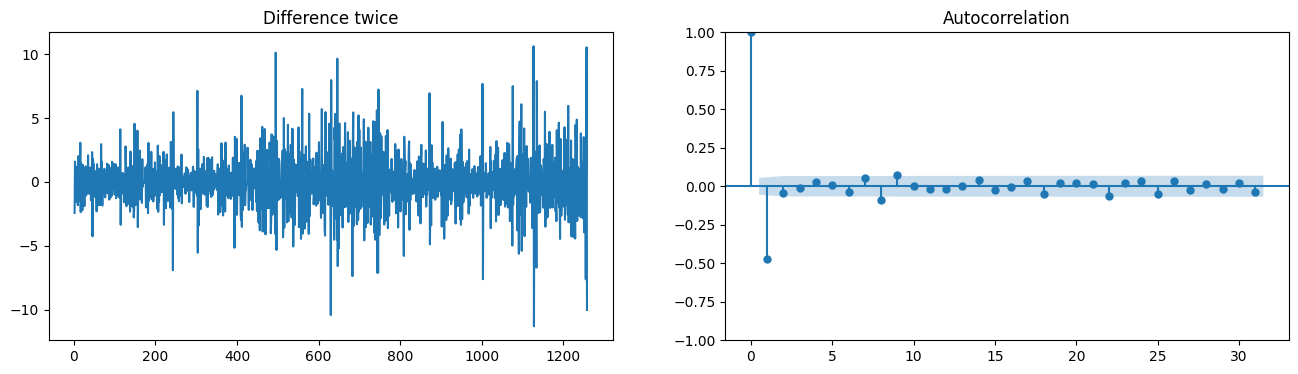

In [20]:
diff2 = df.close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff2)
ax1.set_title('Difference twice')
plot_acf(diff2, ax=ax2);


We can use the pmdarima package to get the number of differencing.

In [17]:
from pmdarima.arima.utils import ndiffs

In [18]:
ndiffs(df.close, test='adf')

1

**p**

p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors. We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. The PACF plot will help us decide the value of p.

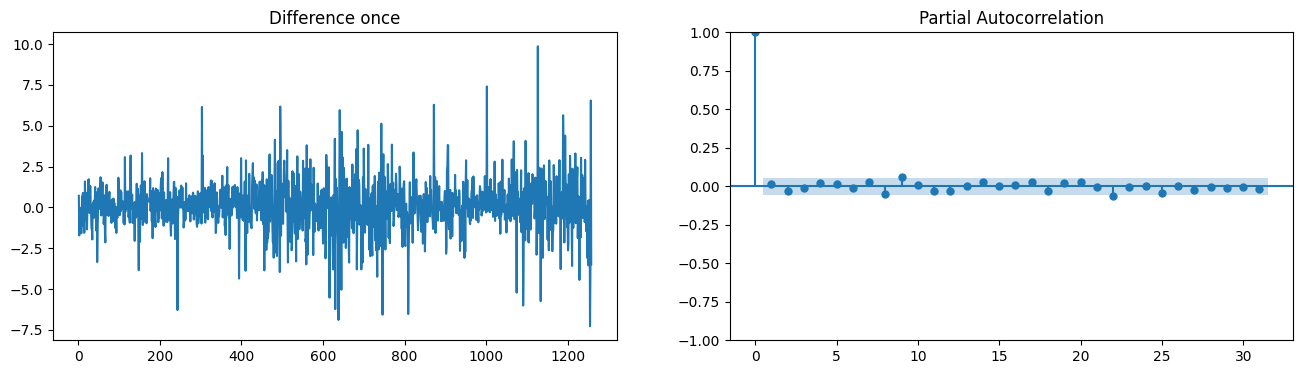

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_pacf(diff1, ax=ax2);

We can observe that the PACF lag 9 is significant since above the significance line. So, we can set p = 9.



**q**

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model. We can find out the required number of MA terms by inspecting the ACF plot.

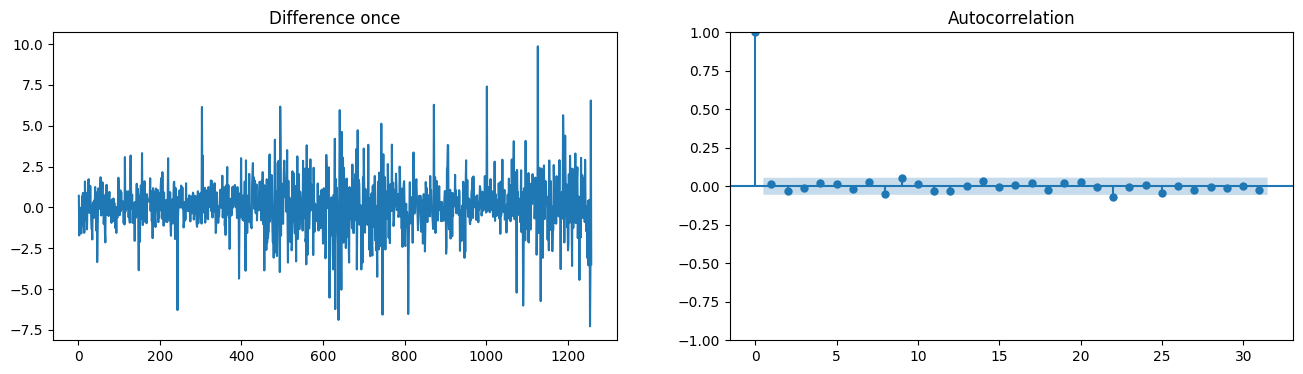

In [25]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

For the ACF plot, we can observe that the ACF lag 9 is significant since above the significance line. So, we can set q = 9.

Fitting the ARIMA model

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming df.close is your time series data
model = ARIMA(df.close, order=(9, 1, 3))
result = model.fit()


/Users/krishan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(9, 1, 3)   Log Likelihood               -2348.232
Date:                Mon, 29 Apr 2024   AIC                           4722.465
Time:                        20:58:03   BIC                           4789.249
Sample:                             0   HQIC                          4747.563
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1592      0.158     -1.006      0.315      -0.469       0.151
ar.L2         -0.5719      0.089     -6.423      0.000      -0.746      -0.397
ar.L3         -0.7010      0.163     -4.296      0.0

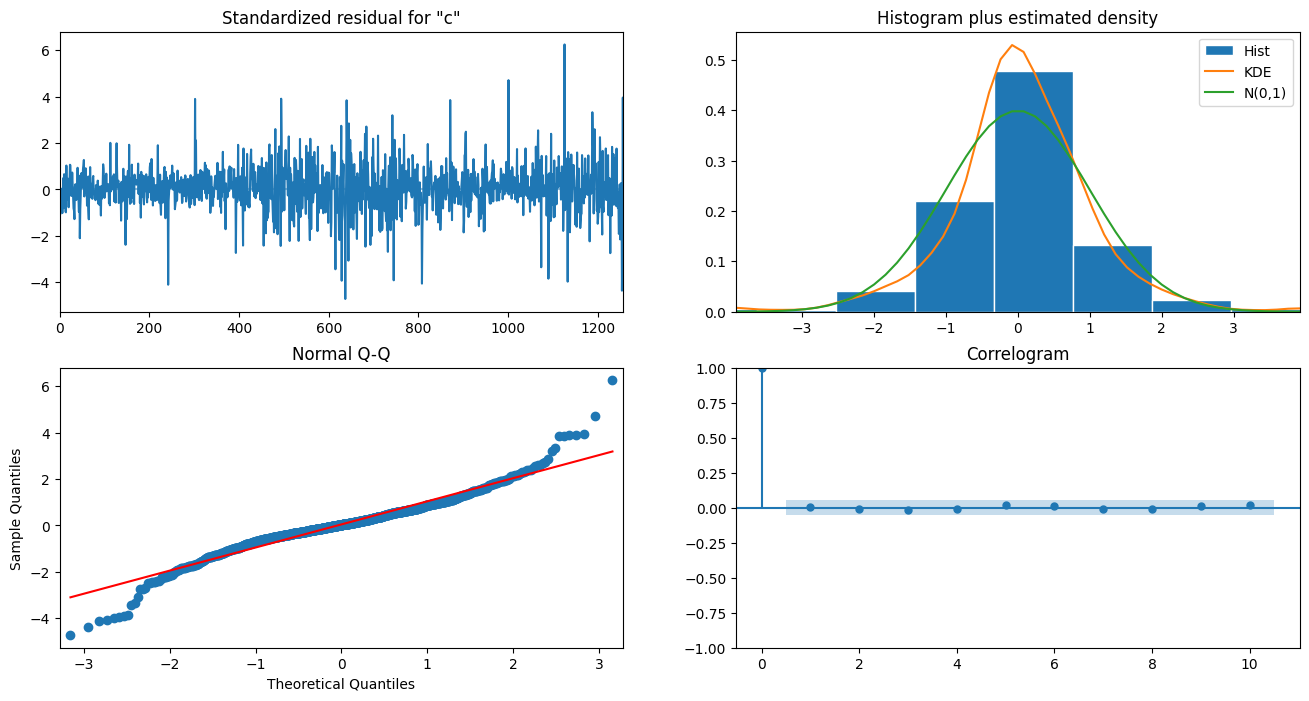

In [30]:
#plot the residuals
result.plot_diagnostics(figsize=(16, 8))
plt.show()

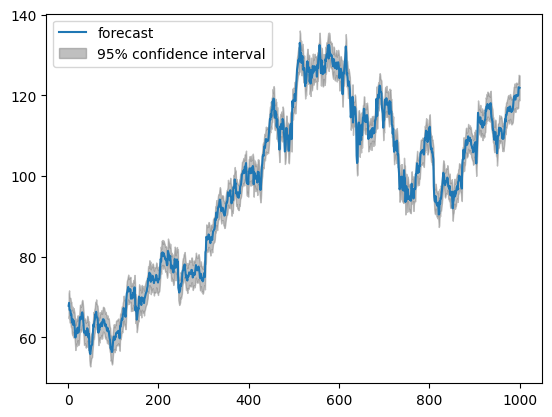

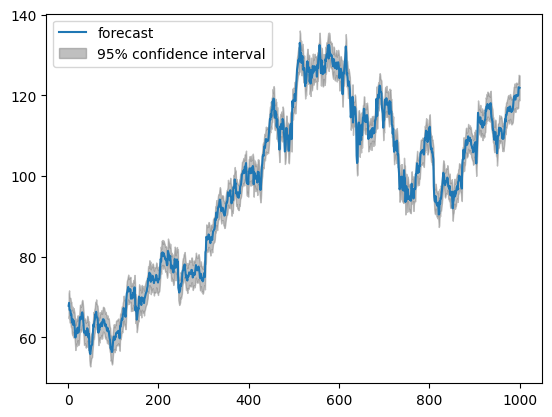

In [35]:
#actual vs forecast
from statsmodels.graphics.tsaplots import plot_predict

# actual vs forecast
plot_predict(result, start=1, end=1000, dynamic=False)
